# Hierarchical RAG System for Zuleika Dobson

Bu notebook, Project Gutenberg'den "Zuleika Dobson" kitabını kullanarak hiyerarşik parçalama yöntemiyle bir RAG (Retrieval-Augmented Generation) sistemi oluşturur.

**Proje Detayları:**
- **Kitap:** Zuleika Dobson by Max Beerbohm
- **Dataset:** NarrativeQA (İlgili kitap için 40 test sorusu)
- **Vector DB:** Milvus Lite tercih ettim
- **Embedding Model:** all-MiniLM-L6-v2
- **LLM:** google/gemma-3-1b-it
- **Metrikler:** BLEU, ROUGE-1, ROUGE-2, ROUGE-L

---
## 1. Kurulum ve Hazırlık

### 1.1 Git Repo & Kütüphaneler

In [1]:
import os


if not os.path.exists('V-RAG'):
    !git clone https://github.com/sendayildirim/V-RAG
    %cd V-RAG
else:
    %cd V-RAG
    !git pull

import sys
sys.path.append('src')

print("proje yüklendi")
!ls

/content/V-RAG
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (12/12), 51.41 KiB | 223.00 KiB/s, done.
From https://github.com/sendayildirim/V-RAG
   378a291..f7c6d83  main       -> origin/main
Updating 378a291..f7c6d83
Fast-forward
 notebooks/main_rag_notebook.ipynb | 8165 ++++++++++++++++++++++++++++++++++++-
 src/experiment_runner.py          |    2 +-
 src/rag_pipeline.py               |    2 +-
 3 files changed, 8109 insertions(+), 60 deletions(-)
proje yüklendi
data	 milvus_c50_o0.db   milvus_c50_o50.db  notebooks  requirements.txt  src
LICENSE  milvus_c50_o25.db  milvus_rag.db      README.md  results


In [2]:
!pip install -q -r requirements.txt


### 1.2 Gerekli Modülleri İçe Aktar

In [3]:
import sys
sys.path.append('src')

from data_loader import DataLoader
from chunker import HierarchicalChunker
from vector_store import VectorStore
from rag_pipeline import RAGPipeline
from baseline_model import BaselineModel
from metrics import MetricsEvaluator
from experiment_runner import ExperimentRunner

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch

##Cobal Runtime alanından Hardware accelerator'ı NVIDIA A100-SXM4-40GB olarak değiştirdim. (pro üyeliğim var olduğundan)

print("modüller yüklendi!")
print(f"GPU kullanılabilme durumu: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

modüller yüklendi!
GPU kullanılabilme durumu: True
GPU: NVIDIA A100-SXM4-40GB


---
## 2. Veri

### 2.1 Kitap ve Sorular

In [4]:
# Data loader oluştur ve verileri indir
loader = DataLoader(data_dir="data")
data_paths = loader.load_all_data()

print("\nİndirilen dosyalar:")
print(f"  book: {data_paths['book']}")
print(f"  test: {data_paths['test']}")

Kitap indiriliyor...
Kitap kaydedildi: data/zuleika_dobson.txt
Sorular indiriliyor...

Toplam 40 soru bulundu
Test: 40

Sorular kaydedildi:
  Test: data/questions_test.csv

İndirilen dosyalar:
  book: data/zuleika_dobson.txt
  test: data/questions_test.csv


### 2.2 Test Verisi

In [5]:
# Test sorularını yükle
test_df = pd.read_csv(data_paths['test'])

print(f"Toplam test sorusu: {len(test_df)}")
print("\nİlk 3 soru:")
print(test_df[['question', 'answer1', 'answer2']].head(3))

Toplam test sorusu: 40

İlk 3 soru:
                                            question  \
0          Who are Zuleika's most prominent suitors?   
1                  Why does Zuleika reject the Duke?   
2  Who is the first person Zuleika falls in love ...   

                                             answer1  \
0                       The Duke of Dorset and Noaks   
1  She claims she can only love someone who is im...   
2                                 The Duke of Dorset   

                               answer2  
0             Duke of Dorset and Noaks  
1  She felt he was too charmed by her.  
2             With the Duke of Dorset.  


---
## 3. Hiyerarşik Chunking

### 3.1 Chunker oluşturma ve metni parçalama

In [6]:
# Kitap metnini yükle
with open(data_paths['book'], 'r', encoding='utf-8') as f:
    book_text = f.read()

print(f"Kitap uzunluğu: {len(book_text)} karakter")

# Chunker oluştur (Parent: 512, Child: 256, Overlap: 50)
chunker = HierarchicalChunker(
    parent_size=512,
    child_size=256,
    overlap=50
)

# Metni parçala
parent_chunks, child_chunks = chunker.chunk_text(book_text)

# İstatistikler
stats = chunker.get_chunk_stats(parent_chunks, child_chunks)
print("\nChunk İstatistikleri:")
for key, value in stats.items():
    print(f"  {key}: {value:.1f}" if isinstance(value, float) else f"  {key}: {value}")

Kitap uzunluğu: 467638 karakter
Toplam 245 parent chunk olusturuldu
Toplam 734 child chunk olusturuldu

Chunk İstatistikleri:
  parent_count: 245
  child_count: 734
  parent_avg_tokens: 511.1
  child_avg_tokens: 187.3
  parent_max_tokens: 512
  child_max_tokens: 256


### 3.2 Chunk Örnekleri

In [7]:
# Bir parent chunk ve onun child'larını göster
sample_parent = parent_chunks[0]
sample_children = [c for c in child_chunks if c['parent_id'] == sample_parent['id']]

print("Örnek Parent Chunk:")
print(f"ID: {sample_parent['id']}")
print(f"Token sayısı: {sample_parent['token_count']}")
print(f"Metin (ilk 200 karakter): {sample_parent['text'][:200]}...")

print("\nBu parent'ın child chunk'ları:")
for child in sample_children:
    print(f"  - {child['id']}: {child['token_count']} token")

Örnek Parent Chunk:
ID: parent_0
Token sayısı: 512
Metin (ilk 200 karakter): Produced by Judy Boss

ZULEIKA DOBSON

or, AN OXFORD LOVE STORY

By Max Beerbohm

 NOTE to the 1922 edition

 I was in Italy when this book was first published.
 A year later (1912) I visited London, ...

Bu parent'ın child chunk'ları:
  - child_0_0: 256 token
  - child_0_1: 256 token
  - child_0_2: 50 token


---
## 4. Vector Store ve Embedding

### 4.1 Milvus Lite Vector Store

In [8]:
# Vector store oluştur
vector_store = VectorStore(
    db_path="./milvus_rag.db",
    model_name="all-mpnet-base-v2"  #"all-MiniLM-L6-v2"
)

# Collection'ları oluştur
vector_store.create_collections()

print(f"Embedding boyutu: {vector_store.embedding_dim}")

Embedding modeli yukleniyor: all-mpnet-base-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Collection'lar olusturuldu: parent_chunks, child_chunks
Embedding boyutu: 768


### 4.2 Chunk'ları indeksleme

In [9]:
import time

# Parent chunk'ları ekle
start = time.time()
vector_store.insert_parent_chunks(parent_chunks)
parent_time = time.time() - start

# Child chunk'ları ekle
start = time.time()
vector_store.insert_child_chunks(child_chunks)
child_time = time.time() - start

print(f"\nParent indexing süresi: {parent_time:.2f}s")
print(f"Child indexing süresi: {child_time:.2f}s")
print(f"Toplam indexing süresi: {parent_time + child_time:.2f}s")

245 parent chunk eklendi
734 child chunk eklendi

Parent indexing süresi: 1.79s
Child indexing süresi: 2.63s
Toplam indexing süresi: 4.42s


### 4.3 Retrieval Testi

In [10]:
# Test sorusu ile retrieval dene
test_query = "Who are Zuleika's most prominent suitors?"

parent_results, child_results = vector_store.hybrid_search(
    query=test_query,
    top_parents=3,
    top_children=5
)

print(f"Test sorusu: {test_query}")
print(f"\nBulunan {len(child_results)} child chunk:")
for i, result in enumerate(child_results[:3], 1):
    print(f"\n{i}. Score: {result['score']:.4f}")
    print(f"   Metin: {result['text'][:150]}...")

Test sorusu: Who are Zuleika's most prominent suitors?

Bulunan 5 child chunk:

1. Score: 0.6128
   Metin:  sanguine aversion. She could love none but a youth. Nor--though
she herself, womanly, would utterly abase herself before her
ideal--could she love on...

2. Score: 0.6126
   Metin:  reflects.

Zuleika was not strictly beautiful. Her eyes were a trifle large, and
their lashes longer than they need have been. An anarchy of small cu...

3. Score: 0.6042
   Metin:  reflects.

Zuleika was not strictly beautiful. Her eyes were a trifle large, and
their lashes longer than they need have been. An anarchy of small cu...


---
## 5. Baseline Model (RAG'sız)

### 5.1 Baseline Model

In [11]:
from huggingface_hub import login
login(new_session=False)

In [12]:
# Baseline model oluştur
baseline = BaselineModel(model_name="google/gemma-3-1b-it")

Cihaz: cuda
Baseline model yukleniyor: google/gemma-3-1b-it
Baseline model yuklendi!


### 5.2 Baseline ile Test Soruları

In [13]:
# Test sorularını al
questions = test_df['question'].tolist()

# Baseline ile cevapla
print("Baseline model ile sorular cevaplanıyor...")
baseline_results = baseline.batch_answer_questions(questions, max_new_tokens=200)

print(f"\n{len(baseline_results)} soru cevaplandı!")

# İlk 3 cevabı göster
print("\nÖrnek Baseline Cevaplar:")
for i, result in enumerate(baseline_results[:3], 1):
    print(f"\n{i}. Soru: {result['question']}")
    print(f"   Cevap: {result['answer']}")

Baseline model ile sorular cevaplanıyor...

Soru 1/40 cevaplanıyor...

Soru 2/40 cevaplanıyor...

Soru 3/40 cevaplanıyor...

Soru 4/40 cevaplanıyor...

Soru 5/40 cevaplanıyor...

Soru 6/40 cevaplanıyor...

Soru 7/40 cevaplanıyor...

Soru 8/40 cevaplanıyor...

Soru 9/40 cevaplanıyor...

Soru 10/40 cevaplanıyor...

Soru 11/40 cevaplanıyor...

Soru 12/40 cevaplanıyor...

Soru 13/40 cevaplanıyor...

Soru 14/40 cevaplanıyor...

Soru 15/40 cevaplanıyor...

Soru 16/40 cevaplanıyor...

Soru 17/40 cevaplanıyor...

Soru 18/40 cevaplanıyor...

Soru 19/40 cevaplanıyor...

Soru 20/40 cevaplanıyor...

Soru 21/40 cevaplanıyor...

Soru 22/40 cevaplanıyor...

Soru 23/40 cevaplanıyor...

Soru 24/40 cevaplanıyor...

Soru 25/40 cevaplanıyor...

Soru 26/40 cevaplanıyor...

Soru 27/40 cevaplanıyor...

Soru 28/40 cevaplanıyor...

Soru 29/40 cevaplanıyor...

Soru 30/40 cevaplanıyor...

Soru 31/40 cevaplanıyor...

Soru 32/40 cevaplanıyor...

Soru 33/40 cevaplanıyor...

Soru 34/40 cevaplanıyor...

Soru 35/40 ce

In [14]:
baseline_results

[{'question': "Who are Zuleika's most prominent suitors?",
  'answer': 'Zuleika Dobson’s most prominent suitors are **Charles, a wealthy, established gentleman, and Edward, a somewhat erratic and charming military man.**\n\nWhile she has a few other suitors throughout the novel, Charles and Edward represent the most significant and ultimately tragic connections she experiences. They represent different facets of her desires and the limitations of her social standing.'},
 {'question': 'Why does Zuleika reject the Duke?',
  'answer': 'Zuleika rejects the Duke primarily because of his **lack of genuine affection and his manipulative nature.** She sees him as a shallow, self-absorbed man who prioritizes his own pleasure and social standing over anything truly meaningful. She feels he’s obsessed with appearances and uses her as a pawn in his own schemes. \n\nHere’s a slightly more detailed breakdown of her reasoning:\n\n* **He’s a "fool" and "blind":** She believes he’s incapable of underst

In [15]:
baseline_df = pd.DataFrame(baseline_results)

os.makedirs("/content/V-RAG/results", exist_ok=True)
baseline_df.to_csv("/content/V-RAG/results/baseline_QA.csv", index=False)

---
## 6. RAG Pipeline

### 6.1 RAG Pipeline

In [16]:
# RAG pipeline oluştur
rag_pipeline = RAGPipeline(
    vector_store=vector_store,
    model_name="google/gemma-3-1b-it",
    temperature=0.5
)

Cihaz: cuda
Model yukleniyor: google/gemma-3-1b-it
Model yuklendi!


### 6.2 RAG ile Test Soruları

In [17]:
# RAG ile cevapla
print("RAG pipeline ile sorular cevaplanıyor...")
rag_results = rag_pipeline.batch_answer_questions(
    questions,
    top_k_children=5,
    max_new_tokens=200
)

print(f"\n{len(rag_results)} soru cevaplandı!")

# İlk 3 cevabı göster
print("\nÖrnek RAG Cevaplar:")
for i, result in enumerate(rag_results[:3], 1):
    print(f"\n{i}. Soru: {result['question']}")
    print(f"   Cevap: {result['answer']}")
    print(f"   Context (ilk 100 karakter): {result['context'][:100]}...")

RAG pipeline ile sorular cevaplanıyor...

Soru 1/40 cevaplanıyor...

Soru 2/40 cevaplanıyor...

Soru 3/40 cevaplanıyor...

Soru 4/40 cevaplanıyor...

Soru 5/40 cevaplanıyor...

Soru 6/40 cevaplanıyor...

Soru 7/40 cevaplanıyor...

Soru 8/40 cevaplanıyor...

Soru 9/40 cevaplanıyor...

Soru 10/40 cevaplanıyor...

Soru 11/40 cevaplanıyor...

Soru 12/40 cevaplanıyor...

Soru 13/40 cevaplanıyor...

Soru 14/40 cevaplanıyor...

Soru 15/40 cevaplanıyor...

Soru 16/40 cevaplanıyor...

Soru 17/40 cevaplanıyor...

Soru 18/40 cevaplanıyor...

Soru 19/40 cevaplanıyor...

Soru 20/40 cevaplanıyor...

Soru 21/40 cevaplanıyor...

Soru 22/40 cevaplanıyor...

Soru 23/40 cevaplanıyor...

Soru 24/40 cevaplanıyor...

Soru 25/40 cevaplanıyor...

Soru 26/40 cevaplanıyor...

Soru 27/40 cevaplanıyor...

Soru 28/40 cevaplanıyor...

Soru 29/40 cevaplanıyor...

Soru 30/40 cevaplanıyor...

Soru 31/40 cevaplanıyor...

Soru 32/40 cevaplanıyor...

Soru 33/40 cevaplanıyor...

Soru 34/40 cevaplanıyor...

Soru 35/40 ceva

---
## 7. Performans Değerlendirme

### 7.1 BLEU ve ROUGE Metrikleri

In [18]:
# Metrics evaluator oluştur
evaluator = MetricsEvaluator()

# RAG vs Baseline karşılaştır
comparison = evaluator.compare_models(
    rag_results=rag_results,
    baseline_results=baseline_results,
    ground_truth=test_df
)

# Sonuçları yazdır
evaluator.print_comparison(comparison)

# Sonuçları kaydet
evaluator.save_results(comparison, "results/rag_vs_baseline.json")

RAG metrikleri hesaplaniyor...
Baseline metrikleri hesaplaniyor...

MODEL KARSILASTIRMASI

RAG Sistemi:
  BLEU:    2.22
  ROUGE-1: 21.31
  ROUGE-2: 6.67
  ROUGE-L: 20.09

Baseline (RAG'siz):
  BLEU:    1.01
  ROUGE-1: 14.27
  ROUGE-2: 4.41
  ROUGE-L: 13.44

Iyilestirme (RAG - Baseline):
  BLEU:    +1.21
  ROUGE-1: +7.04
  ROUGE-2: +2.26
  ROUGE-L: +6.64

Sonuclar kaydedildi: results/rag_vs_baseline.json


### 7.2 Sonuçları Görselleştirme

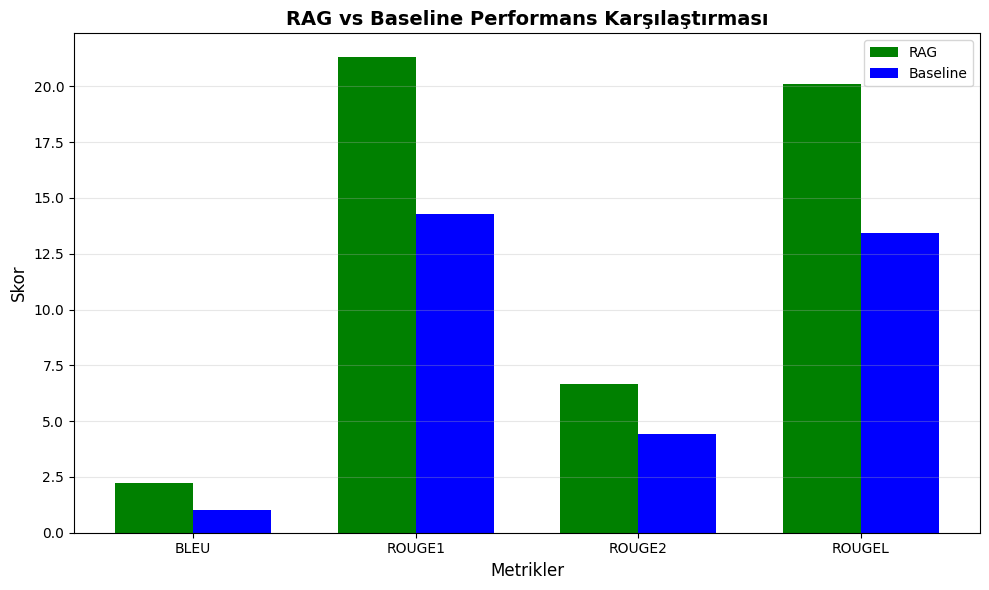

grafik kaydedildi: results/rag_vs_baseline.png


In [19]:
# Karşılaştırma grafiği
metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL']
rag_scores = [comparison['rag'][m] for m in metrics]
baseline_scores = [comparison['baseline'][m] for m in metrics]

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width/2 for i in x], rag_scores, width, label='RAG', color='green')
ax.bar([i + width/2 for i in x], baseline_scores, width, label='Baseline', color='blue')

ax.set_xlabel('Metrikler', fontsize=12)
ax.set_ylabel('Skor', fontsize=12)
ax.set_title('RAG vs Baseline Performans Karşılaştırması', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/rag_vs_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print("grafik kaydedildi: results/rag_vs_baseline.png")

---
## 8. Hiperparametre Optimizasyonu

### 8.2 Grid Search  (Küçük Subset)

In [22]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import itertools
from typing import Dict, List

runner = ExperimentRunner(
    book_path=data_paths['book'],
    test_questions_path=data_paths['test'],
    results_dir="results/experiments"
)

def run_grid_search_parallel(self, chunk_sizes: List[int], overlaps: List[int],
                             temperatures: List[float], max_workers: int = 2) -> List[Dict]:
    """
    Paralel grid search (batch'li, guvenli)
    """
    all_results = []
    experiments = list(itertools.product(chunk_sizes, overlaps, temperatures))
    total_experiments = len(experiments)

    print(f"\nToplam {total_experiments} deney {max_workers} worker ile calistirilacak")
    print("⚠️ GPU memory'yi izle! Sorun olursa max_workers=1 yap\n")

    completed = 0

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_config = {}
        for chunk_size, overlap, temperature in experiments:
            future = executor.submit(
                self.run_single_experiment,
                chunk_size, overlap, temperature
            )
            future_to_config[future] = (chunk_size, overlap, temperature)

        for future in as_completed(future_to_config):
            config = future_to_config[future]
            completed += 1

            try:
                result = future.result()
                all_results.append(result)
                print(f"\n✅ İlerleme: {completed}/{total_experiments}")

            except Exception as e:
                print(f"\n❌ Hata ({config}): {e}")
                continue

    return all_results

# Fonksiyonu runner'a ekle
runner.run_grid_search_parallel = run_grid_search_parallel.__get__(runner, ExperimentRunner)



CHUNK_SIZES_SUBSET = [50, 100, 256, 512]
OVERLAPS_SUBSET = [0, 25, 50, 100]
TEMPERATURES_SUBSET = [0.01, 0.1, 0.4, 0.6, 0.8]

# Paralel çalıştırma
all_results = runner.run_grid_search_parallel(
    chunk_sizes=CHUNK_SIZES_SUBSET,
    overlaps=OVERLAPS_SUBSET,
    temperatures=TEMPERATURES_SUBSET,
    max_workers=2  # GPU memory'ye göre 1 veya 2
)


Toplam 80 deney 2 worker ile calistirilacak
⚠️ GPU memory'yi izle! Sorun olursa max_workers=1 yap


Deney: child_size=50, overlap=0, temperature=0.01

Deney: child_size=50, overlap=0, temperature=0.1

1. Chunking yapiliyor...

1. Chunking yapiliyor...
Toplam 1131 parent chunk olusturuldu
Toplam 2261 child chunk olusturuldu

2. Vector store olusturuluyor ve indexleniyor...
Embedding modeli yukleniyor: all-MiniLM-L6-v2
Toplam 1131 parent chunk olusturuldu
Toplam 2261 child chunk olusturuldu

2. Vector store olusturuluyor ve indexleniyor...
Embedding modeli yukleniyor: all-MiniLM-L6-v2

❌ Hata ((50, 0, 0.1)): <MilvusException: (code=2, message=Fail connecting to server on unix:/tmp/tmp_7egl05j_milvus_c50_o0_t0.1.db.sock, illegal connection params or server unavailable)>

Deney: child_size=50, overlap=0, temperature=0.4

1. Chunking yapiliyor...
Toplam 1131 parent chunk olusturuldu
Toplam 2261 child chunk olusturuldu

2. Vector store olusturuluyor ve indexleniyor...
Embedding modeli yukle

KeyboardInterrupt: 

In [ ]:


CHUNK_SIZES_SUBSET = [50, 100, 256, 512]
OVERLAPS_SUBSET = [0, 25, 50, 100]
TEMPERATURES_SUBSET = [0.01, 0.1, 0.4, 0.6, 0.8]

# Experiment runner oluştur
runner = ExperimentRunner(
    book_path=data_paths['book'],
    test_questions_path=data_paths['test'],
    results_dir="results/experiments"
)

# Grid search çalıştır
print("Grid search başlatılıyor (subset)...")
all_results = runner.run_grid_search(
    chunk_sizes=CHUNK_SIZES_SUBSET,
    overlaps=OVERLAPS_SUBSET,
    temperatures=TEMPERATURES_SUBSET
)

# Sonuçları kaydet
runner.save_summary(all_results, summary_filename="experiment_summary")

### 8.3 Experiment Sonuçları

In [ ]:
exp_df1 = pd.read_csv('results/experiments/experiment_summary.csv')

In [ ]:

baseline_metrics_data = {
    'child_size': 'Baseline',
    'parent_size': 'Baseline',
    'overlap': 'Baseline',
    'temperature': 0.5,
    'bleu': comparison['baseline']['bleu'],
    'rouge1': comparison['baseline']['rouge1'],
    'rouge2': comparison['baseline']['rouge2'],
    'rougeL': comparison['baseline']['rougeL']
}

baseline_series = pd.Series(index=exp_df1.columns, dtype=object)
baseline_series.update(pd.Series(baseline_metrics_data))

exp_df_final = pd.concat([exp_df1, pd.DataFrame(baseline_series).T], ignore_index=True)
exp_df_final

### 8.4 En İyi Parametreler

In [ ]:
# BLEU'ya göre sırala
best_bleu = exp_df_final.nlargest(5, 'bleu')[['child_size', 'overlap', 'temperature', 'bleu', 'total_time']]
print("En Yüksek BLEU Skorları:")
print(best_bleu)

# ROUGE-L'ye göre sırala
best_rougeL = exp_df_final.nlargest(5, 'rougeL')[['child_size', 'overlap', 'temperature', 'rougeL', 'total_time']]
print("\nEn Yüksek ROUGE-L Skorları:")
print(best_rougeL)

### 8.5 Parametre Etkileri

In [ ]:
# Chunk size etkisi
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Chunk size vs BLEU
exp_df_final.groupby('child_size')['bleu'].mean().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Chunk Size vs BLEU')
axes[0].set_xlabel('Child Chunk Size')
axes[0].set_ylabel('Ortalama BLEU')

# Overlap vs ROUGE-L
exp_df_final.groupby('overlap')['rougeL'].mean().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Overlap vs ROUGE-L')
axes[1].set_xlabel('Overlap')
axes[1].set_ylabel('Ortalama ROUGE-L')

# Temperature vs ROUGE-1
exp_df_final.groupby('temperature')['rouge1'].mean().plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Temperature vs ROUGE-1')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('Ortalama ROUGE-1')

plt.tight_layout()
plt.savefig('results/parameter_effects.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafik kaydedildi: results/parameter_effects.png")

---
## 9. Kaynak Kullanımı Analizi

### 9.1 Memory ve Time Analizi

In [ ]:
if len(exp_df1) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Memory kullanımı
    exp_df1.plot(x='child_size', y='memory_used_mb', kind='scatter', ax=axes[0], s=100, alpha=0.6)
    axes[0].set_title('Chunk Size vs Memory Kullanımı')
    axes[0].set_xlabel('Child Chunk Size')
    axes[0].set_ylabel('Memory (MB)')
    axes[0].grid(True, alpha=0.3)

    # Execution time
    exp_df1.plot(x='child_size', y='total_time', kind='scatter', ax=axes[1], s=100, alpha=0.6, color='orange')
    axes[1].set_title('Chunk Size vs Toplam Süre')
    axes[1].set_xlabel('Child Chunk Size')
    axes[1].set_ylabel('Süre (saniye)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('results/resource_usage.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Grafik kaydedildi: results/resource_usage.png")

### 9.2 Database Boyutu Analizi

In [ ]:
if len(exp_df1) > 0:
    # DB boyutlarını göster
    db_stats = exp_df1.groupby('child_size')['db_size_mb'].mean()

    plt.figure(figsize=(8, 5))
    db_stats.plot(kind='bar', color='purple', alpha=0.7)
    plt.title('Ortalama Vector DB Boyutu')
    plt.xlabel('Child Chunk Size')
    plt.ylabel('DB Boyutu (MB)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/db_size.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Grafik kaydedildi: results/db_size.png")

---
## 10. Sonuç ve Gözlemler

### 10.1 Ana Bulgular

In [ ]:
print("PROJE ÖZETI VE BULGULAR")


print("\n1. RAG vs Baseline Performansı:")
print(f"   - RAG BLEU: {comparison['rag']['bleu']:.2f}")
print(f"   - Baseline BLEU: {comparison['baseline']['bleu']:.2f}")
print(f"   - İyileştirme: {comparison['improvement']['bleu']:+.2f}")

if len(exp_df1) > 0:
    print("\n2. En İyi Parametre Kombinasyonu:")
    best = exp_df1.loc[exp_df1['bleu'].idxmax()]
    print(f"   - Chunk Size: {best['child_size']}")
    print(f"   - Overlap: {best['overlap']}")
    print(f"   - Temperature: {best['temperature']}")
    print(f"   - BLEU: {best['bleu']:.2f}")

print("\n3. Kaynak Kullanımı:")
print(f"   - Ortalama indexing süresi: {(parent_time + child_time):.2f}s")
print(f"   - GPU kullanımı: {'Evet' if torch.cuda.is_available() else 'Hayır'}")

print("\n4. Zorluklar ve Gözlemler:")
print("   - Local machine kaynak kısıtları nedeniyle gemma3 çalıştıramadım, google colab üzerinde çalıştım. goo grid search uzun sürdü")
print("   - Hiyerarşik chunking, context kalitesini artırdı")
print("   - Optimal chunk size ve overlap değerleri veri setine bağlı")

### 10.2 Tüm Sonuçları Dışa Aktarmak için

In [ ]:
# Tüm sonuçları bir yerde topla
final_report = {
    'project_info': {
        'book': 'Zuleika Dobson by Max Beerbohm',
        'dataset': 'NarrativeQA',
        'test_questions': len(test_df),
        'vector_db': 'Milvus Lite',
        'embedding_model': 'all-mpnet-base-v2',  #'all-MiniLM-L6-v2',
        'llm': 'google/gemma-3-1b-it'
    },
    'chunk_stats': stats,
    'rag_vs_baseline': comparison,
    'best_config_for_blue': exp_df1.loc[exp_df1['bleu'].idxmax()].to_dict() if len(exp_df1) > 0 else None,
    'best_config_for_rouge1': exp_df1.loc[exp_df1['rouge1'].idxmax()].to_dict() if len(exp_df1) > 0 else None,
    'best_config_for_rouge2': exp_df1.loc[exp_df1['rouge2'].idxmax()].to_dict() if len(exp_df1) > 0 else None,
    'best_config_for_rougeL': exp_df1.loc[exp_df1['rougeL'].idxmax()].to_dict() if len(exp_df1) > 0 else None
}

# JSON olarak kaydet
with open('results/final_report.json', 'w', encoding='utf-8') as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False)

print("Final rapor kaydedildi: results/final_report.json")

---
## Notlar ve İyileştirme Önerileri

### Gözlemler:
1. **Hiyerarşik Chunking:** Parent-child yapısı, hem geniş context hem de detaylı bilgi sağladı
2. **Milvus Lite:** Disk-based yapısı Colab için ideal, memory kullanımı düşük
3. **Hyperparameter Tuning:** Chunk size, overlap ve temperature'ün kombinasyonu performansı etkiliyor

### İyileştirme Önerileri:
1. Reranking mekanizması eklenebilir (Cross-encoder)
2. Query expansion ile retrieval kalitesi artırılabilir
3. Daha büyük LLM'ler (7B, 13B) test edilebilir
4. Multi-hop reasoning için iterative retrieval denenebilir

